# Import libraries

In [1]:
path = '/content/drive/MyDrive/Colab Notebooks/data'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import cv2
import math as m
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
tf.compat.v1.enable_eager_execution()
# Comment this section if running locally
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load train test data

In [3]:
data = None
path_to_data = '/content/drive/MyDrive/Colab Notebooks/data'

with open(path+'/classification_train_test_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data.keys())
# print(type(data['labels']))
train_data = tf.data.Dataset.from_tensor_slices((data['train']['features_rgb'],data['train']['labels']))
test_data = tf.data.Dataset.from_tensor_slices((data['test']['features_rgb'],data['test']['labels']))

dict_keys(['train', 'test', 'class_labels'])


# Split train data to train and validation sets, with a split of 70% 30% split.

In [5]:
# defining some hyperparameters
TRAIN_LENGTH = int(0.7 * len(train_data))
BUFFER_SIZE = 1000
BATCH_SIZE = 48
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Split the dataset into training and testing subsets
train_dataset = train_data.take(TRAIN_LENGTH)
val_dataset =  train_data.skip(TRAIN_LENGTH)


train_ds = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#train_dataset = train_datase
test_ds = test_data.shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



(48, 224, 224, 3)


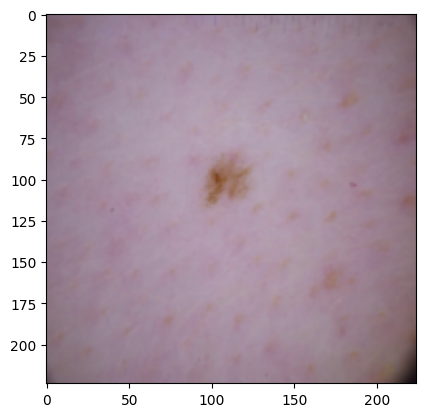

In [6]:
sample_image=None
for i,j in val_ds.take(1):
  sample_image = i
  print(i.shape)
plt.imshow(sample_image[0,:,:,:])

# Load Vgg16 model
- Imagenet weights are being used in pretrained mode.
- All the layers of the base model are frozen

In [7]:
base_model = VGG16(weights='imagenet', include_top=False)


base_model.trainable=False

58889256/58889256 [==============================] - 3s 0us/step


# Addition of Output Dense layer
- dense layer is added at the output layer with soft max as the activation.

In [8]:
inputs = Input(shape=(224,224,3), name='input')
num_classes = 8  # Replace with the number of classes in your problem
x = GlobalMaxPooling2D(input_shape=(None, None, None, 512))(base_model.output)
x = Dense(num_classes, activation='softmax')(x)


# Model compilation

In [9]:

# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()
# calling the model inside the scope
#with strategy.scope():
vgg16model = Model(inputs=base_model.input, outputs=x)
# compiling the model with the optimizer, loss function and acc metrics
vgg16model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model architecture

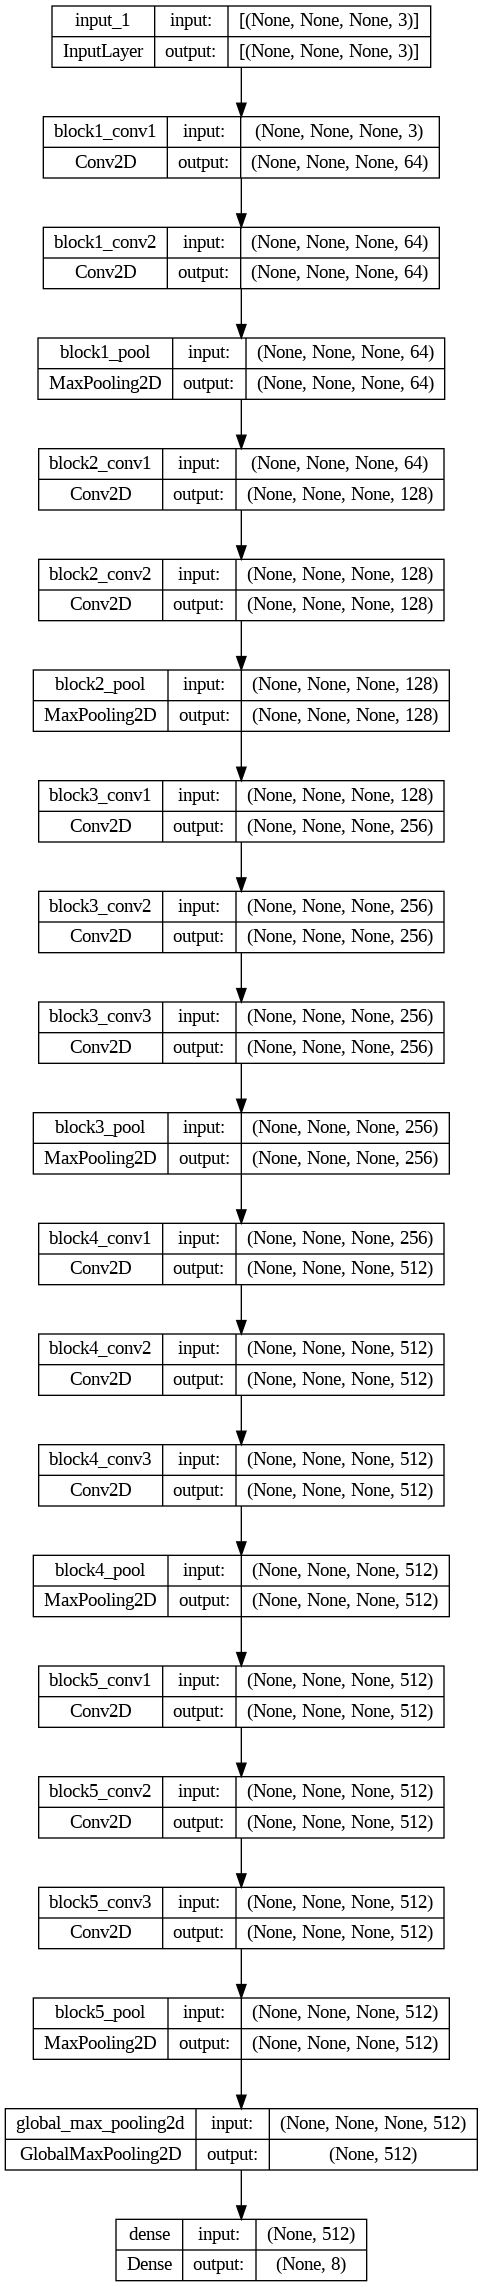

In [10]:
tf.keras.utils.plot_model(vgg16model, show_shapes=True)

# Model summary

In [11]:
vgg16model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Save model and its metrics
- Callbacks are defined for saving the model
- Training metrics are getting logged in a CSV file.
- Learning rate reduces upon encountering plateau

In [12]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

checkpoint_callback = ModelCheckpoint(
    filepath=path+'/Vgg16_ISIC_2019_model.h5',  # Specify the file to save the weights
    save_best_only=True,  # Save only the best model based on the monitored metric
    monitor='val_accuracy',  # Metric to monitor (e.g., validation accuracy)
    mode='max',  # 'max' if higher values are better, 'min' if lower values are better
    verbose=1  # Display messages about the saving process
)


 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

csv_logger = CSVLogger(path+'/vgg16_training_ISIC_2019.csv')
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [15]:
data['train']['labels'][0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

# Compute class weights

In [21]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1,2,3,4,5,6,7],y=np.array(data['train']['labels']).argmax(axis=1))
class_weight_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}




In [22]:
print(class_weight_dict)

{0: 0.74828125, 1: 0.74828125, 2: 0.74828125, 3: 0.8625720461095101, 4: 0.74828125, 5: 3.1341623036649215, 6: 2.963490099009901, 7: 1.192480079681275}


In [24]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 15#info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = vgg16model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds,
                          callbacks=[reduce_lr, early_stopping,csv_logger,checkpoint_callback],class_weight = class_weight_dict)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 1.8498 - accuracy: 0.2959
Epoch 1: val_accuracy improved from -inf to 0.36111, saving model to /content/drive/MyDrive/Colab Notebooks/data/Vgg16_ISIC_2019_model.h5
69/69 [==============================] - 33s 263ms/step - loss: 1.8498 - accuracy: 0.2959 - val_loss: 1.6465 - val_accuracy: 0.3611 - lr: 0.0100
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - ETA: 0s - loss: 1.6007 - accuracy: 0.3735
Epoch 2: val_accuracy improved from 0.36111 to 0.36667, saving model to /content/drive/MyDrive/Colab Notebooks/data/Vgg16_ISIC_2019_model.h5
69/69 [==============================] - 22s 237ms/step - loss: 1.6007 - accuracy: 0.3735 - val_loss: 1.7790 - val_accuracy: 0.3667 - lr: 0.0100
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 1.5038 - accuracy: 0.4131
Epoch 3: val_accuracy improved from 0.36667 to 0.42222, saving model to /content/drive/MyDrive/Colab Notebooks/data/Vgg16_ISIC_2019_model.h5
69/69 [==============================] - 17s 244ms/step - loss: 1.5038 - accuracy: 0.4131 - val_loss: 1.6045 - val_accuracy: 0.4222 - lr: 0.0100
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.4401
Epoch 4: val_accuracy improved from 0.42222 to 0.44167, saving model to /content/drive/MyDrive/Colab Notebooks/data/Vgg16_ISIC_2019_model.h5
69/69 [=========

# Calculate AUC and ROC curves

1/1 [==============================] - 0s 20ms/step
(1198, 8)
0.9954292174755713
0.9942849057532359
0.9901541462996313
0.9879032258064516
0.9954553177030241
0.9990051472814568
0.9877693058691759


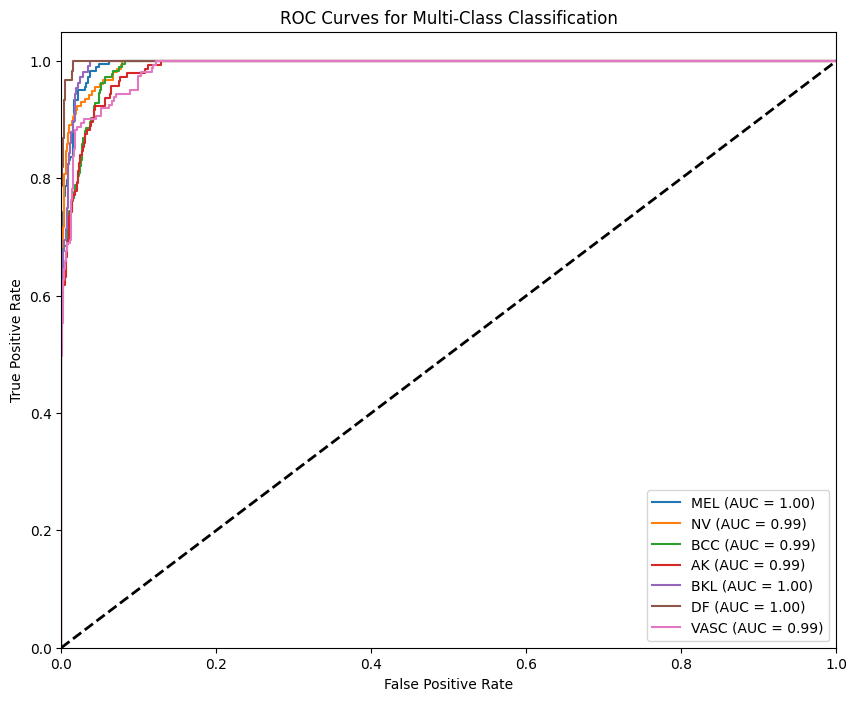

In [78]:
y1,y2 = [],[];cm = np.zeros((8,8));predicted_probs = []
for i,j in test_data:
  #plt.imshow(i)
  x_true =i;y_true=j
  y_pred = vgg16model.predict(tf.expand_dims(i, axis=0))
  # print(y_pred[0])
  y_pred_arg = np.argmax(y_pred)
  predicted_probs.append(y_pred)
  y2.append(y_pred_arg)
  #y_true_arg = np.argmax(y_true)
  y1.append(list(y_true.numpy()))

predicted_probs = np.array(predicted_probs).reshape(len(predicted_probs),8)
print(predicted_probs.shape)

true_labels = np.array(y2)
# MEL	NV	BCC	AK	BKL	DF	VASC	SCC	UNK
labell = {1:'MEL',2:'NV',3:'BCC',4:'AK',5:'BKL',6:'DF',7:'VASC',8:'SCC'}
n_classes = 8  # Replace with the number of classes in your problem

fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC

for i in range(1,n_classes):
    # Create binary labels for the current class (1 if it's the current class, 0 otherwise)
    y_true = np.array([1 if y == i else 0 for y in true_labels])

    # Get the predicted probabilities for the current class
    y_score = predicted_probs[:, i]

    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])


plt.figure(figsize=(10, 8))

for i in range(1,n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labell[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='best')
plt.show()


# Model metrics

In [83]:
import pandas as pd
df = pd.read_csv(path+'/vgg16_training_ISIC_2019.csv')
df.head()

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.295894,1.849829,0.01,0.361111,1.646465
1,1,0.373487,1.600728,0.01,0.366667,1.778982
2,2,0.413136,1.503752,0.01,0.422222,1.604518
3,3,0.440073,1.401295,0.01,0.441667,1.527839
4,4,0.496368,1.307875,0.01,0.406944,1.487992


# Accuracy

<Axes: >

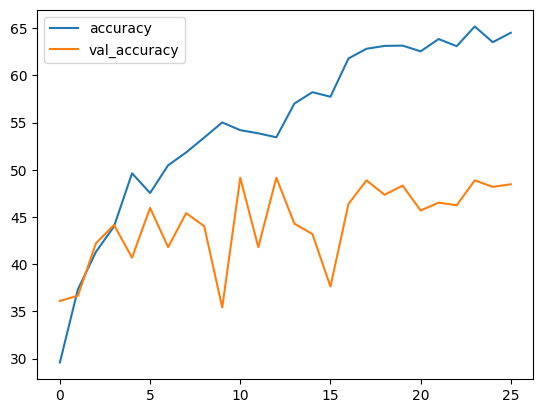

In [84]:
df['accuracy'] = df['accuracy']*100
df['val_accuracy'] = df['val_accuracy']*100
df['val_loss'] = df['val_loss']*100
df['loss'] = df['loss']*100
#df['accuracy'] = df['val_loss']*100

df.loc[:,['accuracy','val_accuracy']].plot()

# Loss

<Axes: >

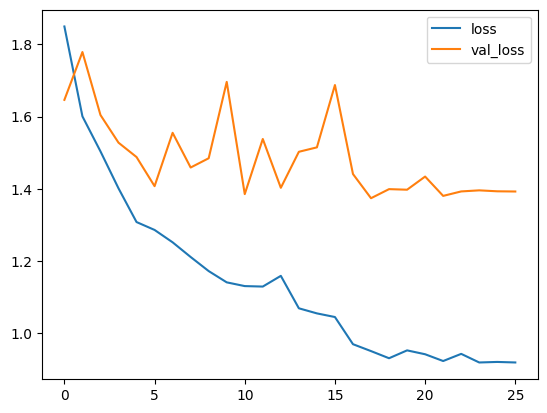

In [82]:
df.loc[:,['loss','val_loss']].plot()

#Fine tuning

In [88]:
base_model.trainable=True
vgg16model.compile(optimizer=Adam(learning_rate=0.01/10000),loss='categorical_crossentropy',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [89]:
csv_logger = CSVLogger(path+'/vgg16_training_ISIC_2019_finetuned.csv')

In [105]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5#info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = vgg16model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds,
                          callbacks=[reduce_lr, early_stopping,csv_logger],class_weight = class_weight_dict)

Epoch 1/10
69/69 [==============================] - 48s 693ms/step - loss: 0.5675 - accuracy: 0.7914 - val_loss: 1.2824 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 2/10
69/69 [==============================] - 47s 688ms/step - loss: 0.5442 - accuracy: 0.7972 - val_loss: 1.4575 - val_accuracy: 0.5458 - lr: 1.0000e-06
Epoch 3/10
69/69 [==============================] - 47s 687ms/step - loss: 0.5268 - accuracy: 0.8081 - val_loss: 1.3752 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 4/10
69/69 [==============================] - 48s 689ms/step - loss: 0.5008 - accuracy: 0.8211 - val_loss: 1.4163 - val_accuracy: 0.5417 - lr: 1.0000e-06
Epoch 5/10
69/69 [==============================] - 47s 685ms/step - loss: 0.4846 - accuracy: 0.8245 - val_loss: 1.3822 - val_accuracy: 0.5542 - lr: 1.0000e-06
Epoch 6/10
69/69 [==============================] - 47s 687ms/step - loss: 0.4671 - accuracy: 0.8347 - val_loss: 1.4755 - val_accuracy: 0.5125 - lr: 1.0000e-06
Epoch 7/10
69/69 [======================

In [ ]:
y_pred = vgg16model.predict(sample_image)

# Evaluation of fine tuned model

In [106]:
df = pd.read_csv(path+'/vgg16_training_ISIC_2019_finetuned.csv')
df['accuracy'] = df['accuracy']*100
df['val_accuracy'] = df['val_accuracy']*100
df['loss'] = df['loss']*100
df['val_loss'] = df['val_loss']*100
acc_df = df.loc[:,['accuracy','val_accuracy']]
loss_df = df.loc[:,['loss','val_loss']]

In [107]:
df.head()

,epoch,accuracy,loss,lr,val_accuracy,val_loss,val_lr
0,0,73.490340,68.169785,0.000001,57.083333,126.520240,NaN
1,1,75.000000,64.664274,0.000001,51.249999,143.053305,NaN
2,2,75.575060,62.888098,0.000001,56.666666,135.553277,NaN
3,3,77.663440,59.840524,0.000001,50.416666,140.408456,NaN
4,0,79.136473,56.754774,0.000001,56.250000,128.237855,NaN


<Axes: >

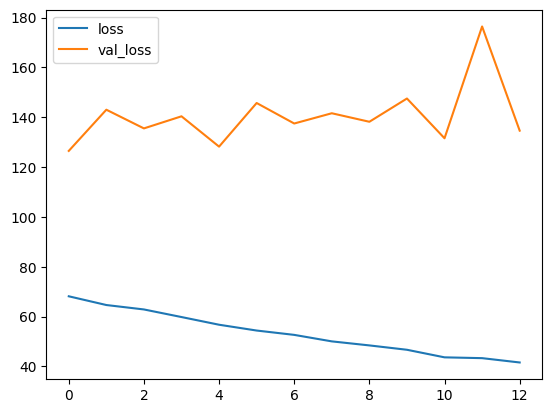

In [109]:
loss_df.plot()